In [3]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plot_loss
from torch import optim
from tqdm.notebook import trange

from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer

In [4]:
dataset = DatasetCombined("../../dataset/v7/")
batch_size = 512
# Read data
dataiterator = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists


In [5]:
(mask_partons, data_partons, 
mask_lepton_partons, data_lepton_partons, 
mask_boost_parton, data_boost_parton, 
data_intermediate, data_intermediate_cartesian,
data_ps, data_ps_detjacinv, 
mask_lepton, data_lepton, mask_jets,
data_jets,mask_met, data_met,
mask_boost_reco,data_boost_reco) =  next(iter(dataiterator))

In [9]:
# Initialize Transformer Layer
transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=8, no_layers=3)

# Obtain conditional_input from transformer (pass batches and masks to `forward` method)
conditional_input = transformer.forward(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)

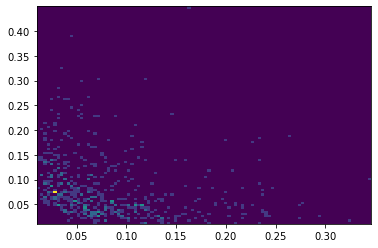

In [10]:
plt.hist2d(conditional_input.detach().numpy()[:, 0], 
           conditional_input.detach().numpy()[:, 1], bins=100) ;

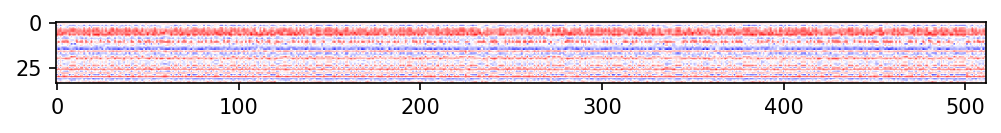

In [11]:
plt.figure(figsize=(8,8), dpi=150)
plt.imshow(conditional_input.T.detach().numpy(), cmap="bwr")

# Setup the flow

In [14]:
import zuko

ModuleNotFoundError: No module named 'zuko'

In [3]:
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform

In [4]:
def build_flow(nfeatures=10, ncond=32, ntransforms=4, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    
    flow = zuko.flows.NSF(features=nfeatures,
                          context=ncond, 
                          transforms=ntransforms, 
                          bins=bins, 
                          hidden_features=hidden_mlp, 
                          randperm=False,
                          base=BoxUniform,
                          base_args=[torch.ones(nfeatures)*(-1),torch.ones(nfeatures)], 
                          univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                          passes= 2 if not autoregressive else nfeatures)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(nfeatures),1*torch.ones(nfeatures),
                                                 -1*torch.ones(nfeatures), 1*torch.ones(nfeatures)))
    
    return flow

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [66]:
fl1 = build_flow(nfeatures=10,
                 ncond=34, 
                 ntransforms=6, 
                 hidden_mlp=[64]*3, 
                 bins=10, 
                 autoregressive=False)

cond_transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=8, no_layers=3)

print(f"parameters, {count_parameters(fl1)}")

parameters, 180320


In [69]:
ps_samples = fl1(conditional_input).sample((100, ))

In [67]:
%%timeit
ps_samples = fl1(conditional_input).sample((1, ))

83.9 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%%timeit
ps_prob = fl1(conditional_input).log_prob(data_ps)

43.8 ms ± 9.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


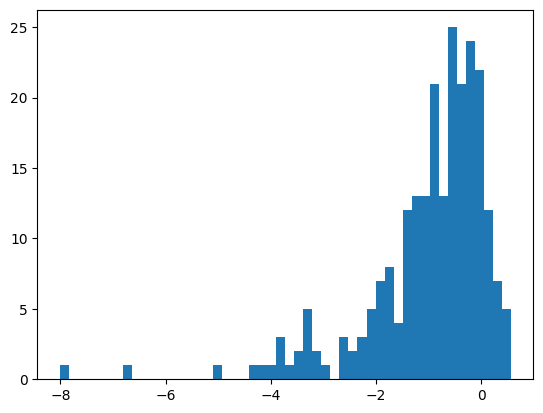

In [63]:
plt.hist(ps_prob.detach().log().numpy(), bins=50);

## Training loop

In [6]:
nepochs = 50
lr_init = 0.0001
batch_size = 512


In [9]:
dataset = DatasetCombined("../../dataset/v7/")
# Read data
dataiterator = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists


In [114]:
cond_transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=4, no_layers=3)

flow = build_flow(nfeatures=10,
                 ncond=34, 
                 ntransforms=6, 
                 hidden_mlp=[128]*2, 
                 bins=16, 
                 autoregressive=True)


optimizer = optim.Adam(list(flow.parameters()) +list(cond_transformer.parameters()) , lr=lr_init)

#decay = 0.01
#fcn = lambda step: 1./(1. + decay*step)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss_epoch","loss"])

print(f"parameters flow:{count_parameters(flow)}, parameters conditioner: {count_parameters(cond_transformer)}")

parameters flow:497432, parameters conditioner: 413101


In [115]:
flow

NSF(
  (transforms): ModuleList(
    (0): SimpleAffineTransform([tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])] -> [tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])])
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=16)
      (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=44, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=128, out_features=470, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=16)
      (order): [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=44, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out

In [116]:
len(dataiterator)

1113

In [117]:
torch.autograd.set_detect_anomaly(True)

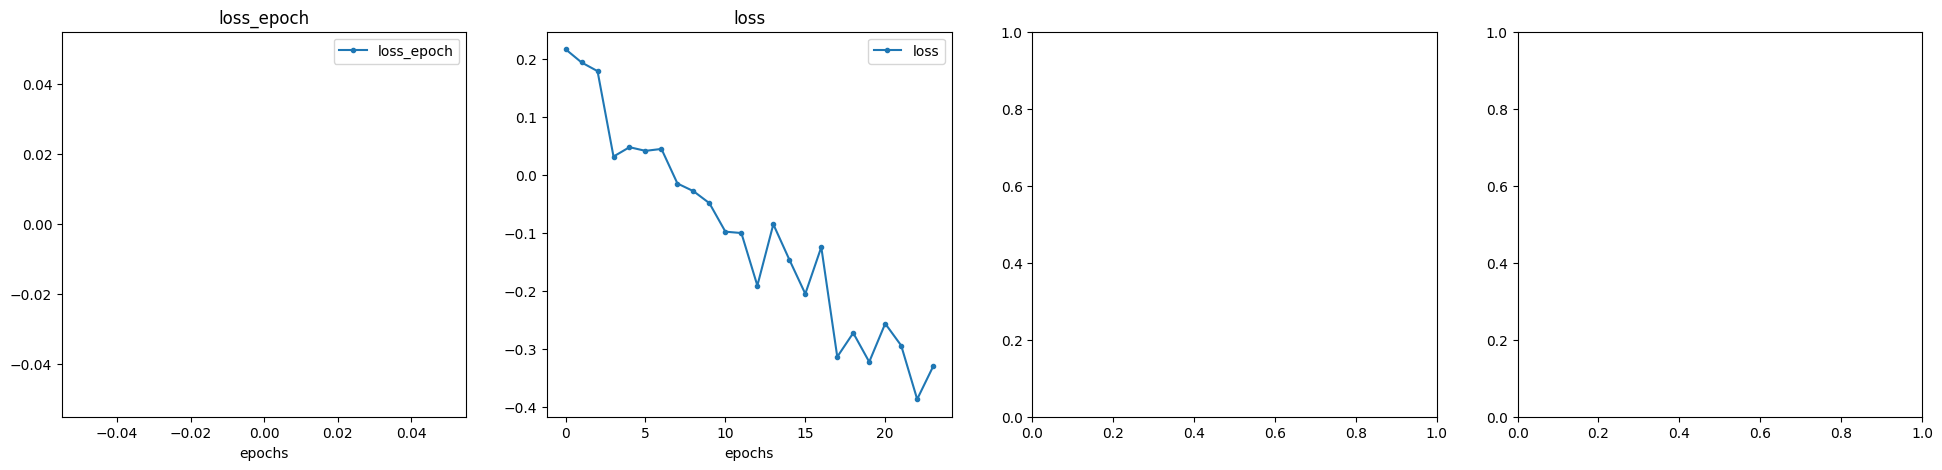

RuntimeError: Function 'LogBackward0' returned nan values in its 0th output.

In [118]:
for e in trange(0, nepochs, desc="Epoch"):
    
    sum_loss = 0.
    N = 0
    t = trange(0, len(dataiterator), batch_size, desc="Batch")
    
    for i, data in enumerate(dataiterator):
        (mask_partons, data_partons, 
        mask_lepton_partons, data_lepton_partons, 
        mask_boost_parton, data_boost_parton, 
        data_intermediate, data_intermediate_cartesian,
        data_ps,  mask_lepton, data_lepton, mask_jets,
        data_jets,mask_met, data_met,
        mask_boost_reco,data_boost_reco) =  data
    
        optimizer.zero_grad()
        
        cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)
        
        logp_g =  flow(cond_X).log_prob(data_ps)  # Be careful, we are probably missing the rambo jacobian
        
        logp_g = torch.nan_to_num(logp_g, posinf=4, neginf=-5)
        
        loss =  -logp_g.mean()
        #print(logp_g.isnan().sum(),logp_g.isinf().sum(), loss.item(),  logp_g)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), 0.1)
        torch.nn.utils.clip_grad_norm_(cond_transformer.parameters(), 0.1)
        optimizer.step()     
        sum_loss += loss.item()

        plotter.on_epoch_end({"loss": loss.item()})
        #t.set_description(f"{loss.item():.4f}", refresh=True)
    plotter.on_epoch_end({"loss_epoch":sum_loss/N})
        
    
#     with torch.no_grad():
#         out = flow(Y_scaled[0:30000]).sample((1, )).squeeze(0)
#         plt.hist2d(out[:,0].numpy(), 
#                    Y_scaled[0:30000,0].numpy(), 
#                    bins=100,cmap="inferno", cmin=1, norm=LogNorm() );
#         plt.xlabel("Pz generated")
#         plt.ylabel("Pz reco (conditioning)")
        
#         # plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
#         #    bins=100, cmap="inferno", cmin=1, norm=LogNorm());
        
#         plt.show()
#         plt.close()


In [36]:
-logp_g.mean()

tensor(-1.1221, grad_fn=<NegBackward0>)

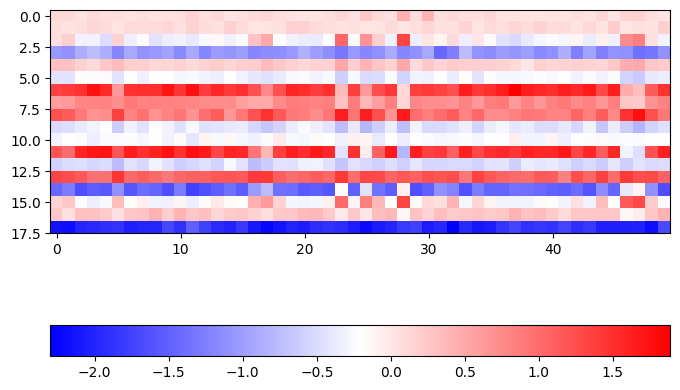

In [110]:
cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)
        
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(cond_X[:50,:].T.detach().numpy(), cmap="bwr")
plt.colorbar(location="bottom")

In [37]:
for p in cond_transformer.parameters():
    print(p)
    


Parameter containing:
tensor([[ 0.0709, -0.1628,  0.0052,  0.1371, -0.1601],
        [-0.3670, -0.1786,  0.1169, -0.4195,  0.3495],
        [-0.3810,  0.4278, -0.1203,  0.0110,  0.0319],
        [ 0.3782,  0.0690,  0.1888,  0.3205, -0.4440],
        [ 0.0289, -0.4276, -0.0661, -0.1414, -0.3998],
        [ 0.1632, -0.0366, -0.2436,  0.1345,  0.0630],
        [-0.3873, -0.2475,  0.1913,  0.4144,  0.3779],
        [-0.4048,  0.3618, -0.4466, -0.1250, -0.3086],
        [ 0.3667,  0.4328,  0.0424, -0.2308, -0.3056],
        [ 0.3541,  0.2779, -0.1379,  0.4180, -0.2389],
        [-0.4309, -0.2922, -0.2151,  0.2041,  0.1368],
        [ 0.1878, -0.3563, -0.1920, -0.3627,  0.2515],
        [-0.4208,  0.3563, -0.2141,  0.1583, -0.2694],
        [-0.3447, -0.1483, -0.0461, -0.3081, -0.0944],
        [-0.1331, -0.1328, -0.0610,  0.1445,  0.3654]], dtype=torch.float32,
       requires_grad=True)
Parameter containing:
tensor([-0.4216,  0.3579, -0.3778,  0.2584, -0.2760,  0.3194,  0.1226,  0.4420,
  

In [38]:
(mask_partons, data_partons, 
        mask_lepton_partons, data_lepton_partons, 
        mask_boost_parton, data_boost_parton, 
        data_intermediate, data_intermediate_cartesian,
        data_ps,  mask_lepton, data_lepton, mask_jets,
        data_jets,mask_met, data_met,
        mask_boost_reco,data_boost_reco) =  data
    

cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)

In [103]:
ps_new = flow(cond_X).sample((50,))

In [68]:
data_ps.shape

torch.Size([512, 10])

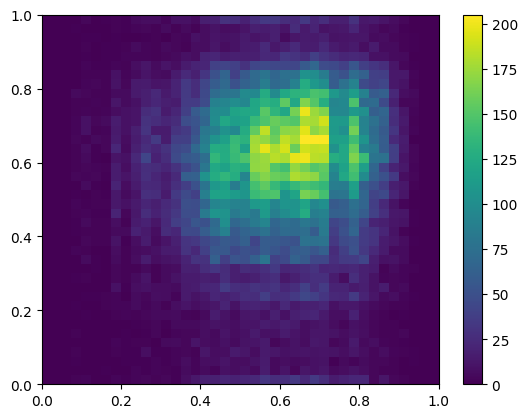

In [105]:
plt.hist2d(data_ps[:,-2:].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,-2:].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

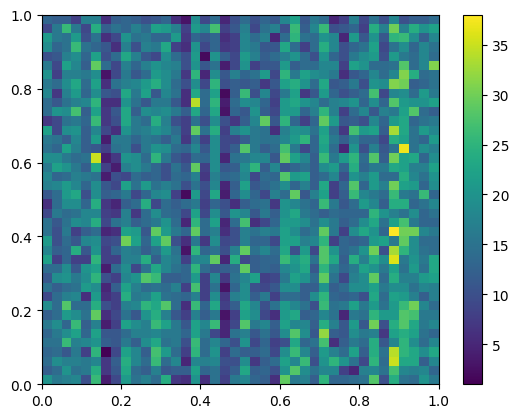

In [109]:
plt.hist2d(data_ps[:,7].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,7].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

(array([  42.,   81.,  101.,  138.,  141.,  154.,  197.,  182.,  213.,
         221.,  247.,  244.,  251.,  238.,  278.,  288.,  263.,  280.,
         334.,  346.,  329.,  370.,  401.,  404.,  429.,  426.,  440.,
         429.,  504.,  523.,  542.,  578.,  604.,  615.,  656.,  680.,
         709.,  773.,  788.,  808.,  891.,  889.,  957., 1000., 1051.,
        1058., 1096., 1095., 1272., 1321., 1245., 1220., 1110., 1086.,
        1045.,  994.,  979.,  972.,  887.,  823.,  818.,  772.,  753.,
         701.,  646.,  647.,  597.,  614.,  492.,  543.,  495.,  509.,
         445.,  433.,  442.,  430.,  406.,  363.,  366.,  331.,  329.,
         302.,  342.,  253.,  288.,  263.,  270.,  232.,  248.,  184.,
         222.,  192.,  169.,  164.,  167.,  160.,  139.,   94.,   79.,
          42.]),
 array([-0.99332244, -0.97341674, -0.95351104, -0.93360535, -0.91369965,
        -0.89379395, -0.87388825, -0.85398255, -0.83407686, -0.81417116,
        -0.79426546, -0.77435976, -0.75445407, -0.734548

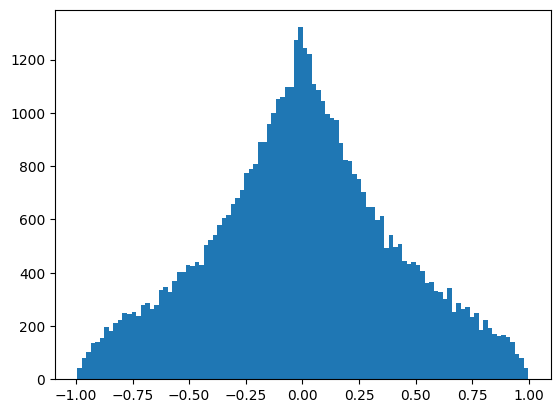

In [53]:
plt.hist((data_ps-ps_new).flatten(), bins=100)